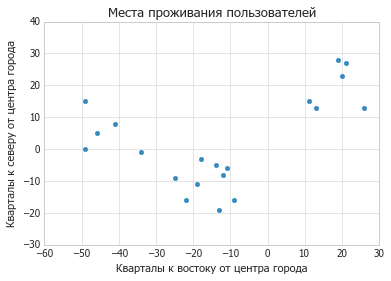

3-means:
[[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]


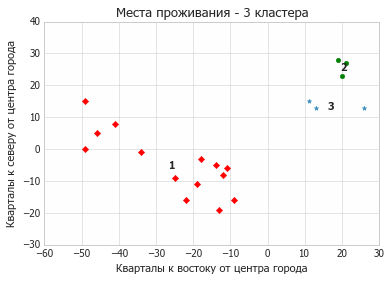

2-means:
[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]


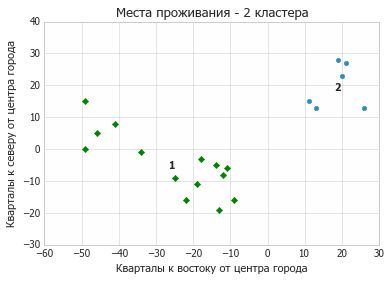

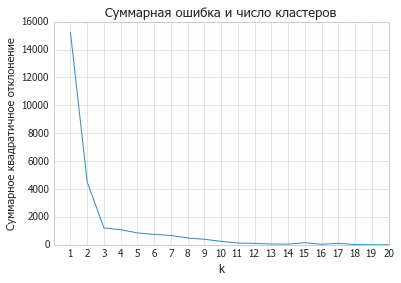

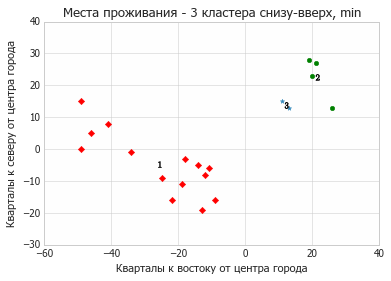

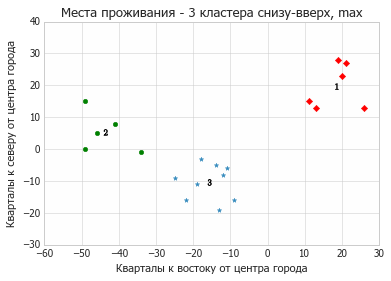

In [2]:
# -*- coding: utf-8 -*-
"""
Глава 19, рис. 1_9
"""

import sys
sys.path.append("../../code-python3-ru")

from lib.linear_algebra import *

import math, random
import matplotlib.image as mpimg
from functools import partial, reduce

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline  

mpl.style.use('ggplot')  
mpl.style.use('seaborn-whitegrid')  
mpl.rcParams['axes.facecolor'] = u'fefefe'
#mpl.rcParams.update({'font.family': 'Ubuntu Condensed'})   
mpl.rcParams.update({'font.family': 'Tahoma'})

#
# Кластеризация по методу К-средних
#
class KMeans:
    """класс выполняет кластеризацию по методу k-средних"""

    def __init__(self, k):
        self.k = k          # число кластеров
        self.means = None   # средние кластеров

    def classify(self, input):
        """вернуть индекс кластера, ближайшего к входящему значению input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):

        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # найти новые назначения
            new_assignments = list(map(self.classify, inputs))

            # если ни одно назначение не изменилось, то завершить
            if assignments == new_assignments:
                return

            # в противном случае сохранить новые назначения
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # удостовериться, что i_points не пуст, чтобы не делить на 0
                if i_points:
                    self.means[i] = vector_mean(i_points)


#
# применение кластеризации для изменения цвета изображения
#

def recolor_image(input_file, k=5):
    img = mpimg.imread(input_file)   
    pixels = [pixel for row in img for pixel in row]
    clusterer = KMeans(k)
    clusterer.train(pixels) # обучение займет некоторое время

    def recolor(pixel):
        cluster = clusterer.classify(pixel) # индекс ближайшего кластера
        return clusterer.means[cluster]     # среднее ближайшего кластера

    new_img = [[recolor(pixel) for pixel in row]
               for row in img]

    plt.imshow(new_img)
    plt.axis('off')
    plt.show()
    #fig.savefig("fig_19-5", dpi=300, bbox_inches='tight', facecolor='w') 
    

#
# иерархическая кластеризация
#

def is_leaf(cluster):
    """кластер является листом, если его длина = 1"""
    return len(cluster) == 1

def get_children(cluster):
    """вернуть два дочерних элемента данного кластера,
    если он – объединенный кластер; вызывает исключение,
    если это листовой кластер"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """вернуть значение в кластере (если это листовой кластер)
    или все значения в листовых кластерах под ним (если нет)"""
    if is_leaf(cluster):
        return cluster # это уже одноэлементный кортеж, содержащий значение
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

def cluster_distance(cluster1, cluster2, distance_agg=min):
    """найти агрегированное расстояние между элементами 
    кластера cluster1 и элементами кластера cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # 1-й элемент 2-элементного кортежа - порядковый номер merge_order 


def bottom_up_cluster(inputs, distance_agg=min):
    # начать с того, что все входы - листовые кластеры (1-элементный кортеж)
    clusters = [(input,) for input in inputs]

    # пока остается более одного кластера...
    while len(clusters) > 1:
        # найти два ближайших кластера
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # исключить их из списка кластеров
        clusters = [c for c in clusters if c != c1 and c != c2]

        # объединить их, используя переменную порядкового номера
        # объединения merge_order = число оставшихся кластеров
        merged_cluster = (len(clusters), [c1, c2])

        # и добавить их объединение к списку кластеров
        clusters.append(merged_cluster)

    # когда останется всего один кластер, то вернуть его
    return clusters[0]

def generate_clusters(base_cluster, num_clusters):
    # sначать со списка, состоящего только из базового кластера
    clusters = [base_cluster]

    # продолжать, пока кластеров не достаточно...
    while len(clusters) < num_clusters:
        # выбрать из кластеров тот, который был объединен последним
        next_cluster = min(clusters, key=get_merge_order)
        # исключить его из списка
        clusters = [c for c in clusters if c != next_cluster]
        # и добавить его дочерние элементы к списку
        # (т. е. разъединить его)
        clusters.extend(get_children(next_cluster))

    # когда уже достаточно кластеров...
    return clusters
    
    
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],
          [-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],
          [-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],
          [-25,-9],[-18,-3]]    


def show_locations():
    fig = plt.figure()
    
    x, y = list(zip(*inputs))
    plt.scatter(x, y, marker='o', color="#348ABD")

    plt.xlim(-60,30)
    plt.ylim(-30,40)
    plt.xlabel("Кварталы к востоку от центра города", fontsize=11)
    plt.ylabel("Кварталы к северу от центра города", fontsize=11)
    plt.title("Места проживания пользователей", fontsize=13)
    plt.show()      
    #fig.savefig("fig_19-1", dpi=300, bbox_inches='tight', facecolor='w') 


def kmeans3():
    fig = plt.figure()
        
    #random.seed(0) # чтобы получить повторимые результаты
    clusterer = KMeans(3)
    clusterer.train(inputs)
    print("3-means:")
    kmeans = clusterer.means
    print(kmeans)    
    
    assignments = list(map(clusterer.classify, inputs))

    g0, g1, g2 = [], [], []

    for i, el in enumerate(assignments):
        if assignments[i] == 0: g0.append(inputs[i])
        if assignments[i] == 1: g1.append(inputs[i])
        if assignments[i] == 2: g2.append(inputs[i])
            
    x0, y0 = list(zip(*g0))
    plt.scatter(x0, y0, marker='D', color='r')
    x0, y0 = list(zip(*g1))
    plt.scatter(x0, y0, marker='o', color='g')
    x0, y0 = list(zip(*g2))
    plt.scatter(x0, y0, marker='*', color='#348ABD')

    x, y = list(zip(*kmeans))
    labels = ['1', '2', '3']
    # назначить метку каждой точке
    for label, i, j in zip(labels, x, y):
        plt.annotate(label,
                     xy=(i, j),       # установить метку для точки
                     xytext=(-2, -4), # и немного сместить ее
                     textcoords='offset points', size=10, fontweight='bold')    

    plt.xlim(-60,30)
    plt.ylim(-30,40)
    plt.xlabel("Кварталы к востоку от центра города", fontsize=11)
    plt.ylabel("Кварталы к северу от центра города", fontsize=11)
    plt.title("Места проживания - 3 кластера", fontsize=13)
    plt.show() 
    #fig.savefig("fig_19-2", dpi=300, bbox_inches='tight', facecolor='w') 


def kmeans2():
    fig = plt.figure()
        
    #random.seed(0) 
    clusterer = KMeans(2)
    clusterer.train(inputs)
    print("2-means:")
    kmeans = clusterer.means
    print(kmeans)   
    
    assignments = list(map(clusterer.classify, inputs))

    g0, g1 = [], []

    for i, el in enumerate(assignments):
        if assignments[i] == 0: g0.append(inputs[i])
        if assignments[i] == 1: g1.append(inputs[i])
            
    x0, y0 = list(zip(*g0))
    plt.scatter(x0, y0, marker='D', color='g')
    x0, y0 = list(zip(*g1))
    plt.scatter(x0, y0, marker='o', color='#348ABD')

    x, y = list(zip(*kmeans))
    labels = ['1', '2']

    for label, i, j in zip(labels, x, y):
        plt.annotate(label,
                     xy=(i, j), 
                     xytext=(-2, -4), 
                     textcoords='offset points', size=10, fontweight='bold')    

    plt.xlim(-60,30)
    plt.ylim(-30,40)
    plt.xlabel("Кварталы к востоку от центра города", fontsize=11)
    plt.ylabel("Кварталы к северу от центра города", fontsize=11)
    plt.title("Места проживания - 2 кластера", fontsize=13)
    plt.show() 
    #fig.savefig("fig_19-3", dpi=300, bbox_inches='tight', facecolor='w') 



def squared_clustering_errors(inputs, k=5):
    """находит суммарное квадратичное отклонение (ошибку) 
    от k-средних при кластеризации входящих данных"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))


def plot_squared_clustering_errors():
    fig = plt.figure()
        
    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors, color="#348ABD")
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("Суммарное квадратичное отклонение", fontsize=11) 
    plt.title("Суммарная ошибка и число кластеров", fontsize=13) 
    plt.show()
    #fig.savefig("fig_19-4", dpi=300, bbox_inches='tight', facecolor='w') 



def hierarchical_clustering():
    print("bottom up hierarchical clustering")

    base_cluster = bottom_up_cluster(inputs)
    print(base_cluster)

    print()
    print("three clusters, min:")
    three_clusters_min = generate_clusters(base_cluster, 3)
    for cluster in three_clusters_min:
        print(get_values(cluster))

    print()
    print("three clusters, max:")
    base_cluster = bottom_up_cluster(inputs, max)
    three_clusters_max = generate_clusters(base_cluster, 3)
    for cluster in three_clusters_max:
        print(get_values(cluster))


def get_hierarchical_clustering(f):
    base_cluster = bottom_up_cluster(inputs,f)
    three_clusters = generate_clusters(base_cluster, 3)
    return [get_values(cluster) for cluster in three_clusters]


def plot_hierarchical_clustering_min():
    fig = plt.figure()
    
    base_cluster = bottom_up_cluster(inputs,min)
    three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]

    for i, cluster, marker, color in zip([1, 2, 3],
             three_clusters, 
            ['D','o','*'],
             ['r','g','#348ABD']):
        xs, ys = zip(*cluster)  # волшебный трюк с разъединением списка
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # установить число в среднее значение кластера
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
    plt.xlabel("Кварталы к востоку от центра города", fontsize=11) 
    plt.ylabel("Кварталы к северу от центра города", fontsize=11)
    plt.title("Места проживания - 3 кластера снизу-вверх, min", fontsize=13) 
    plt.show()
    #fig.savefig("fig_19-6", dpi=300, bbox_inches='tight', facecolor='w') 


def plot_hierarchical_clustering_max():
    fig = plt.figure()
          
    base_cluster = bottom_up_cluster(inputs,max)
    three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]

    for i, cluster, marker, color in zip([1, 2, 3],
             three_clusters, 
            ['D','o','*'],
             ['r','g','#348ABD']):
        xs, ys = zip(*cluster)  # волшебный трюк с разъединением списка
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # установить число в среднее значение кластера
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
    plt.xlabel("Кварталы к востоку от центра города", fontsize=11) 
    plt.ylabel("Кварталы к северу от центра города", fontsize=11)
    plt.title("Места проживания - 3 кластера снизу-вверх, max", fontsize=13) 
    plt.show()
    #fig.savefig("fig_19-7", dpi=300, bbox_inches='tight', facecolor='w') 


show_locations()                     #1
kmeans3()                            #2
kmeans2()                            #3

plot_squared_clustering_errors()    #4
#recolor_image("gold_reserves.jpg")         #5
plot_hierarchical_clustering_min()  #6
plot_hierarchical_clustering_max()  #7